# 3) Are Females More Likely to Complete High School Under Islamic or Secular Regime?

[Vitor Kamada](https://www.linkedin.com/in/vitor-kamada-1b73a078)


E-mail: econometrics.methods@gmail.com

Last updated: 10-3-2020

Let's open the data from Meyersson (2014). Each row represents a municipality in Turkey. 

In [1]:
# Load data from Meyersson (2014)
import numpy as np
import pandas as pd
path = "https://github.com/causal-methods/Data/raw/master/" 
df = pd.read_stata(path + "regdata0.dta")
df.head()

,province_pre,ilce_pre,belediye_pre,province_post,ilce_post,belediye_post,vshr_islam2004,educpop_1520f,hischshr614m,hischshr614f,hischshr1520m,hischshr1520f,hvshr1520m,hvshr1520f,hischshr2125m,hischshr2125f,hischshr2630m,hischshr2630f,hiedshr2630m,hiedshr2630f,hischshr3164m,hischshr3164f,hischshr65m,hischshr65f,hischshrunkm,hischshrunkf,studshr1530m,studshr1530f,hwfshr1530f,msshr1530marm,msshr1530marf,lpop,ageshr19,ageshr60,litshrm,litshrf,litshrt,sexr,merkezi,merkezp,...,ahischshr30_34m,nevm30_34m,ahischshr35_39m,nevm35_39m,ahischshr40m,nevm40m,ahischshr15_29m,ahischshr15_39m,ahischshr15_19f,nevm15_19f,ahischshr20_24f,nevm20_24f,ahischshr25_29f,nevm25_29f,ahischshr30_34f,nevm30_34f,ahischshr35_39f,nevm35_39f,ahischshr40f,nevm40f,ahischshr15_29f,ahischshr15_39f,vshr_islam2009,wshr_islam,wshr_noislam,femshr,bp_eduprvshr,bp_edushr,litshr_r,jhischshr1520f,jhischshr1520m,jhivshr1520f,jhivshr1520m,rpopshr1520,rpopshr2125,rpopshr2630,rpopshr3164,nonagshr1530f,nonagshr1530m,anyc
0,Adana,Aladag,Aladag,Adana,Aladag,Aladag,0.367583,540.0,0.0,0.0,0.379310,0.229630,0.023707,0.011111,0.435897,0.227129,0.281588,0.123188,0.180505,0.061594,0.090991,0.028054,0.012422,0.012739,NaN,0.000000,0.288955,0.181818,0.627537,0.177515,0.314210,8.805975,0.422086,0.075067,0.950532,0.791104,0.869156,0.977481,1.0,0.0,...,0.707921,0.290640,0.571429,0.148387,0.205714,0.020000,0.571970,0.607466,0.273292,0.913043,0.670588,0.467836,0.556213,0.230769,0.349398,0.192771,0.253333,0.120000,0.032857,0.050000,0.512000,0.432598,0.407586,0.0,0.0,0.0,NaN,0.0,0.832274,0.318519,0.478448,0.012963,0.025862,1.116244,1.113730,0.955681,0.954823,0.046778,0.273176,1.0
1,Adana,Aladag,Akoren,Adana,Aladag,Akoren,0.518204,342.0,0.0,0.0,0.308901,0.254386,0.020942,0.020468,0.528302,0.228723,0.352113,0.105769,0.065728,0.033654,0.066256,0.011864,0.000000,0.000000,NaN,NaN,0.257745,0.204607,0.018970,0.179678,0.331978,8.345455,0.440988,0.063405,0.931852,0.742810,0.842682,1.120342,0.0,0.0,...,0.536232,0.442857,0.583333,0.216216,0.074074,0.049383,0.597015,0.581590,0.225806,0.967742,0.682927,0.536585,0.604651,0.386364,0.216216,0.243243,0.138889,0.131579,0.011583,0.046332,0.530435,0.393617,0.538780,0.0,0.0,0.0,NaN,NaN,0.797133,0.383041,0.513089,0.023392,0.020942,1.002742,0.993227,1.093731,1.018202,0.020325,0.146221,0.0
2,Adana,Buyuksehir,Buyuksehir,Adana,,Buyuksehir,0.397450,76944.0,0.0,0.0,0.226284,0.226827,0.056218,0.035376,0.288813,0.248201,0.176117,0.161516,0.123987,0.104232,0.136044,0.101161,0.037939,0.017055,0.17037,0.107143,0.238787,0.170477,0.546009,0.288199,0.467399,13.938356,0.435477,0.055400,0.945740,0.824876,0.884187,0.974625,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.872202,0.316048,0.348721,0.036871,0.060343,1.006071,1.094471,1.039968,0.990001,0.148594,0.505949,1.0
3,Adana,Ceyhan,Sarimazi,Adana,Ceyhan,Sarimazi,0.559827,318.0,0.0,0.0,0.173134,0.182390,0.071642,0.022013,0.262172,0.099502,0.216216,0.083333,0.081081,0.039216,0.119094,0.040712,0.000000,0.008130,0.00000,0.000000,0.171492,0.159059,0.031812,0.291759,0.408022,8.579980,0.418107,0.054470,0.960321,0.835707,0.903282,1.181073,0.0,0.0,...,0.575163,0.078947,0.431818,0.060150,0.187599,0.001587,0.501104,0.506775,0.179775,0.910112,0.538462,0.396947,0.379562,0.181159,0.179688,0.061538,0.068702,0.068702,0.038737,0.055954,0.346067,0.265625,0.527235,0.0,0.0,0.0,NaN,0.0,0.870238,0.267296,0.331343,0.022013,0.074627,1.124591,0.891861,0.816490,0.916518,0.040111,0.347439,0.0
4,Adana,Ceyhan,Sagkaya,Adana,Ceyhan,Sagkaya,0.568675,149.0,0.0,0.0,0.328467,0.369128,0.036496,0.053691,0.455446,0.268293,0.357143,0.190909,0.061224,0.027273,0.209932,0.116705,0.000000,0.013333,0.00000,NaN,0.199405,0.146597,0.005236,0.196429,0.350785,7.776954,0.363103,0.096855,0.953730,0.843486,0.898401,1.022901,0.0,0.0,...,0.485714,0.514286,0.641026,0.282051,0.232283,0.074510,0.464912,0.505319,0.200000,1.000000,0.727273,0.636364,0.470588,0.361111,0.435897,0.238095,0.351852,0.309091,0.093863,

The variable 'hischshr1520f' is the proportion of female aged 15-20 that completed high school according to the 2000 census. Unfortunately, the age is aggregated. It is unlikely that 15 and 16 year old teenagers can finish high school in Turkey. It would be better to have the data broken by age. As the 15 and 16 year old cannot be removed from the analysis, the proportion of female aged 15-20 that completed high school is very low: 16.3%. 

The variable 'i94' is 1 if an Islamic mayor won the municipality election in 1994, and 0 if a secular mayor won. The Islamic party governed 12% of the municipalities in Turkey.

In [36]:
# Drop missing values
df = df.dropna(subset=['hischshr1520f', 'i94'])

# Round 2 decimals
pd.set_option('precision', 4)

# Summary Statistics
df.loc[:, ('hischshr1520f', 'i94')].describe()[0:3]

,hischshr1520f,i94
count,2632.0000,2632.0000
mean,0.1631,0.1197
std,0.0958,0.3247


The average high school attainment for the females aged 15-20 is 14% in the municipalities governed by an Islamic major versus 16.6% in the municipalities governed by a secular major.

This is a naive comparison, because the data is not from an experiment. The mayor type was not randomized and cannot be randomized in practice. For example, poverty might lead to a higher level of religiosity and a lower educational achievement. It might be poverty that causes lower rate of high school attainment rather than religion. 

In [37]:
df.loc[:, ('hischshr1520f')].groupby(df['i94']).agg([np.size, np.mean])

,size,mean
i94,,
0.0,2317.0,0.1662
1.0,315.0,0.1404


The graphic "Naive Comparison" shows that control group and treatment group are determined based on the variable 'iwm94': Islamic win margin. This variable was centralized to 0. Therefore, if win margin is above 0, the Islamic mayor won on the election. By the other hand, if win margin is below 0, the Islamic mayor lost the election.

In terms of average high school attainment, the difference between treatment group (14%) and control group (16.6%) is -2.6%. The problem of comparing municipal outcomes using observational data is that the treatment group is not similar to the control group. Therefore, confound factors might bias the results. 



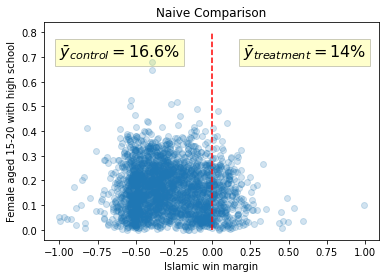

In [38]:
import matplotlib.pyplot as plt

# Scatter plot with vertical line
plt.scatter(df['iwm94'], df['hischshr1520f'], alpha=0.2)
plt.vlines(0, 0, 0.8, colors='red', linestyles='dashed')

# Labels
plt.title('Naive Comparison')
plt.xlabel('Islamic win margin')
plt.ylabel('Female aged 15-20 with high school')

# Control vs Treatment
plt.text(-1, 0.7, r'$\bar{y}_{control}=16.6\%$', fontsize=16,
         bbox={'facecolor':'yellow', 'alpha':0.2})
plt.text(0.2, 0.7, r'$\bar{y}_{treatment}=14\%$', fontsize=16,
         bbox={'facecolor':'yellow', 'alpha':0.2})
plt.show()

This 2.6% difference between high school attainment governed by an Islamic major and a secular major is statistically significant at 1% level of significance. The magnitude is also relevant given that the mean value of high school completion is 16.3%. However, note that it is a naive comparison and likely to be biased. 

In [39]:
# Naive Comparison
df['Intercept'] = 1
import statsmodels.api as sm
naive = sm.OLS(df['hischshr1520f'], df[['Intercept', 'i94']],
                    missing='drop').fit()
print(naive.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1662      0.002     83.813      0.000       0.162       0.170
i94           -0.0258      0.006     -4.505      0.000      -0.037      -0.015


One way to figure out if the naive comparison is likely to be biased is to check if the municipalities ruled by the Islamic major is different from the municipalities ruled by a secular major. 

The municipalities, where the Islamic major won, have higher Islamic vote share in 1994 (41% vs 10%), bigger number of parties receiving votes (5.9 vs 5.5), bigger log population (8.3 vs 7.7), higher population share below 19 year old (44% vs 40%), bigger household size (6.4 vs 5.75), higher proportion of district center (39% vs 33%), and higher proportion of province center (6.6% vs 1.6%).

In [58]:
df = df.rename(columns={"shhs"   : "household",
                        "merkezi": "district",
                        "merkezp": "province"})

control = ['vshr_islam1994', 'partycount', 'lpop1994',
           'ageshr19', 'household', 'district', 'province']
full = df.loc[:, control].groupby(df['i94']).agg([np.mean]).T
full.index = full.index.get_level_values(0)
full

i94,0.0,1.0
vshr_islam1994,0.1012,0.4145
partycount,5.4907,5.8889
lpop1994,7.7745,8.3154
ageshr19,0.3996,0.4453
household,5.7515,6.4449
district,0.3375,0.3937
province,0.0168,0.0667


One way to make control and treatment group similar to each other is to use multiple regression. The interpretation of the coefficient of the treatment variable 'i94' is *ceteris paribus*, that is, the impact of Islamic major on high school attainment considering everything else constant. The trick here is the "everything else constant" that means only the factors that is controlled in the regression. This is an imperfect solution, because in practical terms, it is not possible to control for all factors that affect the outcome variable. However, compared to the simple regression, the multiple regression is likely to suffer less from the omitted variable bias. 

The multiple regression below challenges the result of the naive comparison. Islamic regime has a positive impact of 1.4% higher high school completion compared with a secular regime. The result is statistically significant at 5%.

In [7]:
multiple = sm.OLS(df['hischshr1520f'],
                      df[['Intercept', 'i94'] + control],
                      missing='drop').fit()
print(multiple.summary().tables[1])                      

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2626      0.015     17.634      0.000       0.233       0.292
i94                0.0139      0.006      2.355      0.019       0.002       0.026
vshr_islam1994    -0.0894      0.013     -6.886      0.000      -0.115      -0.064
partycount        -0.0038      0.001     -3.560      0.000      -0.006      -0.002
lpop1994           0.0159      0.002      7.514      0.000       0.012       0.020
ageshr19          -0.6125      0.021    -29.675      0.000      -0.653      -0.572
household          0.0057      0.001      8.223      0.000       0.004       0.007
district           0.0605      0.004     16.140      0.000       0.053       0.068
province           0.0357      0.010      3.499      0.000       0.016       0.056


The result of the multiple regression looks counter intuitive. How the sign of the treatment variable can change? 

Let's look at data from other perspective. The graph "Naive Comparison" is the scatterplot of all municipalities. Each dot is one municipality. It is hard to see any pattern or trends. 

Let's plot the same graphic, but with municipalities aggregated in 29 bins based on similarity of the outcome variable high school completion. These bins are the blue balls in the graphic below. The size of the ball is proportional to the number of municipalities used to calculate the mean value of high school completion. 

If you look carefully near the cut-off (vertical red line), where the variable Islamic win margin = 0, you will see a discontinuity or a jump in the level of high school completion. 

In [8]:
# Library for Regression Discontinuity
!pip install rdd

  Created wheel for rdd: filename=rdd-0.0.3-cp36-none-any.whl size=4719 sha256=651912efad4e2f138cd0d965237531d887c7b9055914f12b9c16398f59651dde
  Stored in directory: /root/.cache/pip/wheels/d9/05/bb/ddeaae29aff613c6588736b4b0ee4c652b5ef7bddcb0d828f8
Successfully built rdd


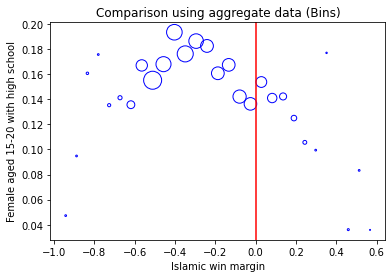

In [9]:
from rdd import rdd

# Aggregate the data in 29 bins
threshold = 0
data_rdd = rdd.truncated_data(df, 'iwm94', 0.99, cut=threshold)
data_binned = rdd.bin_data(data_rdd, 'hischshr1520f', 'iwm94', 29)

# Labels
plt.title('Comparison using aggregate data (Bins)')
plt.xlabel('Islamic win margin')
plt.ylabel('Female aged 15-20 with high school')

# Scatterplot 
plt.scatter(data_binned['iwm94'], data_binned['hischshr1520f'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='blue')

# Red Vertical Line
plt.axvline(x=0, color='red')

plt.show()

Maybe you are not convinced that there is a discontinuity or a jump in the cut-off point. Let's plot the same graphic with 10 bins and restrict the bandwidth (range) of the variable Islamic win margin. Rather than choosing an arbitrary bandwidth (h), let's use a method developed by Imbens & Kalyanaraman (2012) to get the optimal bandwidth that minimizes the mean squared error.

The optimal bandwidth ($\hat{h}$) is 0.23, that is, let's get a window of 0.23 below and above the cut-off to create the 10 bins.

In [10]:
#  Optimal Bandwidth based on Imbens & Kalyanaraman (2012)
#  This bandwidth minimizes the mean squared error.
bandwidth_opt = rdd.optimal_bandwidth(df['hischshr1520f'],
                              df['iwm94'], cut=threshold)
bandwidth_opt

0.23981615165215744

Below are the 10 bins. There are 5 bins in the control group, where the Islamic win margin < 0, and 5 bins in the treatment group, where the Islamic win margin > 0. See that high school completion jumps from 13.8% to 15.5% between index 4 and 5, respectively bins 5 and 6. The values 13.8% and 15.5% were computed based on respectively 141 and 106 municipalities ('n_obs').

In [11]:
#  Aggregate the data in 10 bins using Optimal Bandwidth
data_rdd = rdd.truncated_data(df, 'iwm94', bandwidth_opt, cut=threshold)
data_binned = rdd.bin_data(data_rdd, 'hischshr1520f', 'iwm94', 10)
data_binned

,0,hischshr1520f,iwm94,n_obs
0,0.0,0.176904,-0.215940,136.0
1,0.0,0.160160,-0.168535,142.0
2,0.0,0.169584,-0.121130,162.0
3,0.0,0.128838,-0.073725,139.0
4,0.0,0.138126,-0.026320,141.0
5,0.0,0.155374,0.021085,106.0
6,0.0,0.139527,0.068490,81.0
7,0.0,0.143719,0.115895,58.0
8,0.0,0.140833,0.163300,36.0
9,0.0,0.099652,0.210705,19.0


In the graphic "Comparison using Optimum Bandwidth (h = 0.27)", a blue line was fitted to the control group (5 bins), and an orange line was fitted to the treatment group (5 bins). Now, the discontinuity or jump is clear. We call this method Regression Discontinuity (RD).  The red vertical line ($\hat{\tau}_{rd}=3.5$%) is the increase of high school completion. Note that this method mimics an experiment. The municipalities where the Islamic party barely won and barely lost are likely to be similar to each other. The intuition is that "barely won" and "barely lost" is a random process like flip a coin. The reverse result in the election could occur at random. By the other hand, it is hard to imagine that Islamic mayors could lose in the 
municipalities where they won by a stronger margin of 30%.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


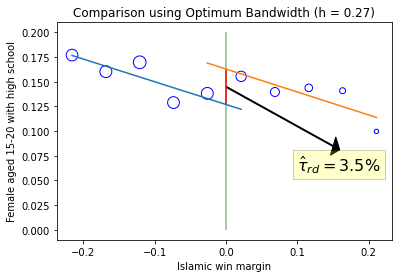

In [12]:
# Scatterplot
plt.scatter(data_binned['iwm94'], data_binned['hischshr1520f'],
    s = data_binned['n_obs'], facecolors='none', edgecolors='blue')

# Labels
plt.title('Comparison using Optimum Bandwidth (h = 0.27)')
plt.xlabel('Islamic win margin')
plt.ylabel('Female aged 15-20 with high school')

# Regression
x = data_binned['iwm94']
y = data_binned['hischshr1520f']

c_slope , c_intercept = np.polyfit(x[0:5], y[0:5], 1)
plt.plot(x[0:6], c_slope*x[0:6] + c_intercept)

t_slope , t_intercept  = np.polyfit(x[5:10], y[5:10], 1)
plt.plot(x[4:10], t_slope*x[4:10] + t_intercept)

# Vertical Line
plt.vlines(0, 0, 0.2, colors='green', alpha =0.5)
plt.vlines(0, c_intercept, t_intercept, colors='red', linestyles='-')

# Plot Black Arrow
plt.axes().arrow(0, (t_intercept + c_intercept)/2, 
         dx = 0.15, dy =-0.06, head_width=0.02,
         head_length=0.01, fc='k', ec='k')

# RD effect
plt.text(0.1, 0.06, r'$\hat{\tau}_{rd}=3.5\%$', fontsize=16,
         bbox={'facecolor':'yellow', 'alpha':0.2})

plt.show()

In [13]:
# RD effect given by the vertical red line
t_intercept - c_intercept

0.0358457081289425

Let's restrict the sample to the municipalities where the Islamic mayor won or lost by a margin of 5%. We can see that the control group and the treatment group are more similar to each other than the comparison using the full sample in the beginning of this chapter. 

However, this similarity is not closer to a "perfect experiment". Part of the reason is the small sample size of the control and treatment group. Therefore, when we run the Regression Discontinuity, it is advisable to add the control variables.

In [59]:
# bandwidth (h) = 5%
df5 = df[df['iwm94'] >= -0.05]
df5 = df5[df5['iwm94'] <= 0.05]

sample5 = df5.loc[:, control].groupby(df5['i94']).agg([np.mean]).T

sample5.index = full.index.get_level_values(0)
sample5

i94,0.0,1.0
vshr_islam1994,0.3026,0.3558
partycount,5.9730,5.8807
lpop1994,8.2408,8.2791
ageshr19,0.4415,0.4422
household,6.2888,6.4254
district,0.4595,0.4037
province,0.0338,0.0826


Let's formalize the theory of Regression Discontinuity.

Let the $D_r$ be a dummy variable: 1 if the unit of analysis receives the treatment, and 0 otherwise. The subscript $r$ indicates that the treatment ($D_r$) is a function of the running variable $r$.

$$D_r =  1 \ or \ 0$$

In the Sharp Regression Discontinuity, the treatment ($D_r$) is determined by the running variable ($r$).

$$D_r =  1, \ if \ r \geq r_0$$

$$D_r =  0, \ if \ r < r_0$$

where, $r_0$ is an arbitrary cutoff or threshold.

The most basic specification of the Regression Discontinuity is:

$$Y = \beta_0+\tau D_r+ \beta_1r+\epsilon$$

where $Y$ is the outcome variable, $\beta_0$ the intercept, $\tau$ the impact of the treatment variable ($D_r$), $\beta_1$ the coefficient of the running variable ($r$), and $\epsilon$ the error term.

Note that in an experiment, the treatment is randomized, but in Regression Discontinuity, the treatment is completely determined by the running variable. The opposite of a random process is a deterministic process. It is counter-intuitive, but the deterministic assignment has the same effect of randomization, when the rule (cutoff) that determines the treatment assignment is arbitrary. 

In general, the credibility of observational studies is very weak, because of the fundamental problem of the omitted variable bias (OVB). Many unobserved factors inside the error term might be correlated with the treatment variable. Therefore, the big mistake in a regression framework is to leave the running variable inside the error term.

Among all estimators, Regression Discontinuity is probably the closer method to the golden standard, randomized experiment. The main drawback is that Regression Discontinuity only captures the local average treatment effect (LATE). It is unreasonable to generalize the results to the entities outside the bandwidth. 

The impact of Islamic mayor is 4% higher female school completion, using a Regression Discontinuity with bandwidth of 5%. This result is statistically significant at level of significance 5%.

In [15]:
#  Real RD specification
#  Meyersson (2014) doesn't use the interaction term, because 
# the results are unstable. In general the coefficient,
# of the interaction term is not statistically significant.
# df['i94_iwm94'] = df['i94']*df['iwm94']
# RD = ['Intercept', 'i94', 'iwm94', 'i94_iwm94']

RD = ['Intercept', 'i94', 'iwm94']

# bandwidth of 5%
df5 = df[df['iwm94'] >= -0.05]
df5 = df5[df5['iwm94'] <= 0.05]
rd5 = sm.OLS(df5['hischshr1520f'],
                      df5[RD + control],
                      missing='drop').fit()
print(rd5.summary()) 

                            OLS Regression Results                            
Dep. Variable:          hischshr1520f   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     36.32
Date:                Sat, 03 Oct 2020   Prob (F-statistic):           1.67e-40
Time:                        14:15:37   Log-Likelihood:                 353.09
No. Observations:                 257   AIC:                            -686.2
Df Residuals:                     247   BIC:                            -650.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.3179      0.043      7.

The impact of Islamic mayor is 2.1% higher female school completion, using a Regression Discontinuity with optimal bandwidth 0.27 calculated based on Imbens & Kalyanaraman (2012). This result is statistically significant at level of significance 1%.

Therefore, the Regression Discontinuity estimators indicate that the naive comparison is biased in the wrong direction.

In [16]:
# bandwidth_opt is 0.2715
df27 = df[df['iwm94'] >= -bandwidth_opt]
df27 = df27[df27['iwm94'] <= bandwidth_opt]
rd27 = sm.OLS(df27['hischshr1520f'],
                      df27[RD + control],
                      missing='drop').fit()
print(rd27.summary()) 

                            OLS Regression Results                            
Dep. Variable:          hischshr1520f   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     128.8
Date:                Sat, 03 Oct 2020   Prob (F-statistic):          5.95e-161
Time:                        14:15:37   Log-Likelihood:                 1349.9
No. Observations:                1020   AIC:                            -2680.
Df Residuals:                    1010   BIC:                            -2630.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2943      0.023     12.

## Exercises

1| Use the data from Meyersson (2014) to run a Regression Discontinuity: a) with full sample, and b) another with bandwidth of 0.1 (10% for both sides). Use the same specification of the two examples of this chapter. Interpret the coefficient of the treatment variable. What is more credible the result of "a" or "b"? Justify.

2| Below is the histogram of the variable Islamic win margin. Do you see any discontinuity or abnormal pattern where the cutoff = 0? What is the rationality of investigating if something weird is going on around the cutoff of the running variable?

In [17]:
import plotly.express as px
fig = px.histogram(df, x="iwm94")
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0 = 0, y1 = 1,
      xref= 'x', x0 = 0, x1 = 0)])
fig.show()

3| I modified the variable "Islamic win margin" for educational purpose. Suppose this is the real running variable from Meyersson (2014). See the histogram below. In this hypothetical situation, what can you infer about the elections in Turkey? Is there a problem in running Regression Discontinuity in this situation? If yes, what can you do to solve the problem?

In [18]:
def corrupt(variable):
    if variable <= 0 and variable >= -.025:
        return 0.025
    else:   
        return variable

df['running'] = df["iwm94"].apply(corrupt)

fig = px.histogram(df, x="running")
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0 = 0, y1 = 1,
      xref= 'x', x0 = 0, x1 = 0)])
fig.show()

4| Explain the graphic below for somebody who is an expert in Machine Learning, but is not trained in Causal Inference? Could the variable "Islamic vote share" be used as running variable? Speculate.

In [19]:
def category(var):
    if var <= 0.05 and var >= -.05:
        return "5%"
    else:   
        return "rest"

df['margin'] = df["iwm94"].apply(category)

fig = px.scatter(df, x="vshr_islam1994", y="iwm94", color ="margin",
                 labels={"iwm94": "Islamic win margin",
                         "vshr_islam1994": "Islamic vote share"})
fig.update_layout(shapes=[
    dict(
      type= 'line',
      yref= 'paper', y0 = 1/2, y1 = 1/2,
      xref= 'x', x0 = 0, x1 = 1)])
fig.show()

5| Are males more likely to complete high school under Islamic or secular regime? Justify your answer based on data and rigorous analysis. The variable "hischshr1520m" is the proportion of males aged 15-20 with high school education.

## Reference

Imbens, G., & Kalyanaraman, K. (2012). Optimal Bandwidth Choice for the Regression Discontinuity Estimator. The Review of Economic Studies, 79(3), 933-959.

Meyersson, Erik. (2014). [Islamic Rule and the Empowerment of the Poor and Pious](https://github.com/causal-methods/Papers/raw/master/Islamic%20Rule%20and%20the%20Empowerment%20of%20the%20Poor%20and%20Pious.pdf). Econometrica, 82(1), 229-269.  